Keys: ['superpoint_heatmap']
Dataset name: superpoint_heatmap
number of dimensions: 2
shape of the data: (952, 1280)
shape of the original image: (952, 1280)


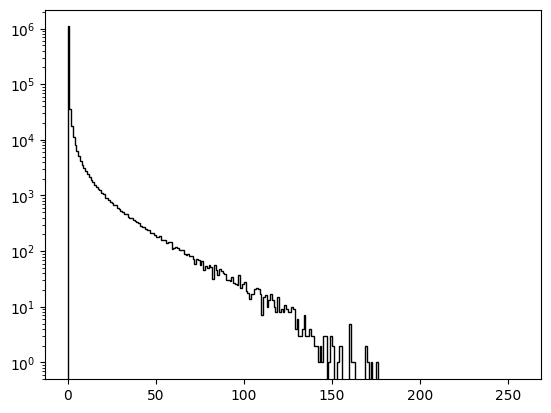

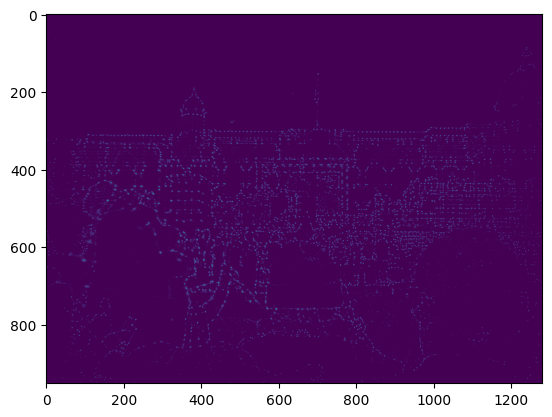

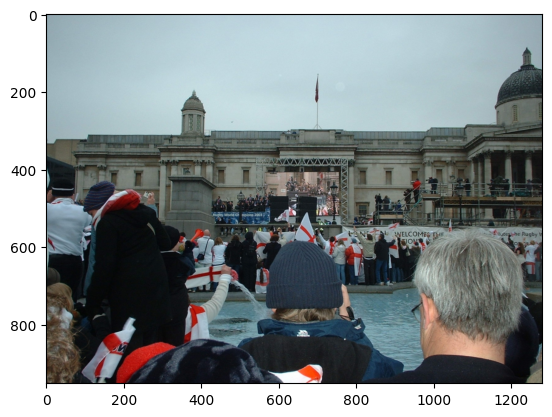

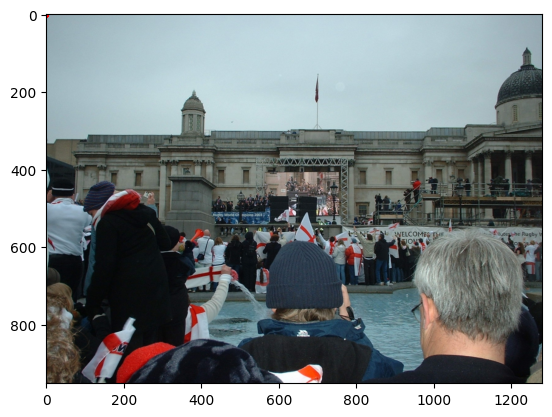

In [1]:
path = '/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/outputs/results/superpoint_gt/0001/9954507_bb75b36ced_o.hdf5'
original_path = '/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/data/minidepth/images/0001/9954507_bb75b36ced_o.jpg'

# read the hdf5 file
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(path, 'r') as f:

    print(f"Keys: {list(f.keys())}")

    dataset_name = list(f.keys())[0]
    print(f"Dataset name: {dataset_name}")
    image_data = f[dataset_name][:]

    print(f"number of dimensions: {image_data.ndim}")

    print(f"shape of the data: {image_data.shape}")
    print(f"shape of the original image: {image_data.shape}")

    # use log scale for the histogram
    plt.hist(image_data.flatten()*255, bins=256, range=[0, 256], color='k', histtype='step', log=True)
    plt.show()

    # show the image
    plt.imshow(image_data, cmap='viridis')
    plt.show()

    original_image = plt.imread(original_path)
    plt.show(plt.imshow(original_image))

    # superipose the points on the image
    plt.imshow(original_image)
    plt.scatter(image_data[:, 0], image_data[:, 1], c='r', s=3)
    plt.show()




In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# File paths
path = '/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/outputs/results/superpoint_gt/0001/9954507_bb75b36ced_o.hdf5'
original_path = '/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/data/minidepth/images/0001/9954507_bb75b36ced_o.jpg'

# Open the HDF5 file
with h5py.File(path, 'r') as f:
    print(f"Keys: {list(f.keys())}")
    dataset_name = list(f.keys())[0]
    print(f"Dataset name: {dataset_name}")
    heatmap = f[dataset_name][:]

    print(f"Heatmap shape: {heatmap.shape}")
    print(f"Heatmap min: {heatmap.min()}, max: {heatmap.max()}")

# Load the original image
original_image = np.array(Image.open(original_path))
original_h, original_w = original_image.shape[:2]
heatmap_h, heatmap_w = heatmap.shape

# Resize heatmap to match the original image resolution (if necessary)
if (heatmap_h != original_h) or (heatmap_w != original_w):
    resized_heatmap = cv2.resize(heatmap, (original_w, original_h), interpolation=cv2.INTER_LINEAR)
else:
    resized_heatmap = heatmap

# Threshold the heatmap to extract points
threshold = 0.5  # Adjust threshold
points = np.argwhere(resized_heatmap > threshold)  # Get (row, col) of points above the threshold

# Superimpose points on the original image
plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.scatter(points[:, 1], points[:, 0], c='r', s=3, label="Keypoints")  # Flip (row, col) to (x, y)
plt.legend()
plt.title("Original Image with Superimposed Keypoints")
plt.axis("off")
plt.show()


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

class KPExtractor:
    def __init__(self, config):
        self.threshold_type = config.get('threshold_type', 'nms')
        self.threshold_value = config.get('threshold_value', 0.75)
        self.max_keypoints = config.get('max_keypoints', 1000)

    def extract_keypoints(self, file_path):
        with h5py.File(file_path, 'r') as f:
            keypoints = f['keypoints'][()]
            scores = f['scores'][()]

            if self.threshold_type == 'nms':
                mask = scores >= self.threshold_value
                selected_keypoints = keypoints[mask]
            else:
                idx = np.argsort(scores)[::-1]
                selected_keypoints = keypoints[idx][:self.max_keypoints]

            return selected_keypoints

class GTGenerator:
    def __init__(self, config):
        self.source_dir = config['source_dir']
        self.output_dir = config['output_dir']
        self.file_format = config.get('file_format', 'hdf5')
        self.output_format = config.get('output_format', 'numpy')
        self.extractor = KPExtractor(config.get('extractor_config', {}))

    def get_hdf5_files(self):
        files = []
        for root, _, filenames in os.walk(self.source_dir):
            files.extend([os.path.join(root, f) for f in filenames if f.endswith(self.file_format)])
        return files

    def save_keypoints(self, keypoints, file_path):
        output_file = os.path.join(self.output_dir, os.path.relpath(file_path, self.source_dir))
        output_dir = os.path.dirname(output_file)
        os.makedirs(output_dir, exist_ok=True)
        np.save(output_file, keypoints)

    def run(self):
        files = self.get_hdf5_files()
        for file_path in files:
            keypoints = self.extractor.extract_keypoints(file_path)
            self.save_keypoints(keypoints, file_path)


In [ ]:
config = {
    'source_dir': "/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/outputs/results/superpoint_gt",
    'output_dir': "data/superpoint_gt",
    'file_format': 'hdf5',
    'output_format': 'numpy',
    'extractor_config': {
        'threshold_type': 'nms',
        'threshold_value': 0.75,
        'max_keypoints': 1000
    }
}

generator = GTGenerator(config)
generator.run()



(4535, 2)


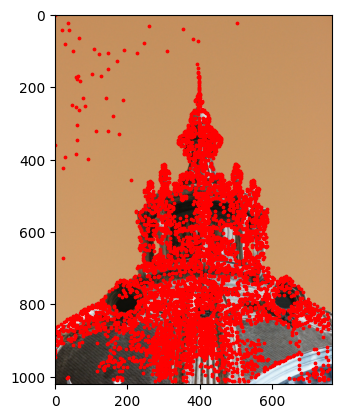

In [14]:
import cv2

path = "/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/notebooks/data/superpoint_gt/0455/4028119231_b8255c6b67_b.npy"
path2 = "/media/egoedeke/a9a96a4d-b323-489e-a833-13f4ade040c8/glue-factory/data/minidepth/images/0455/4028119231_b8255c6b67_b.jpg"

image = cv2.imread(path2)

keypoints = np.load(path)

print (keypoints.shape)

for kp in keypoints:
    plt.scatter(kp[1], kp[0], c='r', s=3)

plt.imshow(image)
plt.show()